In [1]:
import os
import re
import cv2
import glob
import math
import skimage
import random
import numpy as np
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import defaultdict
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
plt.style.use('default')

In [2]:
font_dirs = ['C:/Users/charr/Downloads/DM_Serif_Display',]
font_files = fm.findSystemFonts(fontpaths = font_dirs)
fm.fontManager.addfont(font_files[0])
mpl.rcParams['font.family'] = 'DM Serif Display'

In [3]:
class Resize:
    
    @staticmethod
    def resize_and_one(bbox_image, output_height, output_width):
        bbox_image = skimage.transform.resize(bbox_image, 
                                              output_shape = (output_height, output_width),
                                              anti_aliasing = False)
        bbox_image[bbox_image != 0] = 1
        return bbox_image
    
    def resize(self, output_height, output_width):
        self.data = (skimage.transform.resize(self.data, 
                                              output_shape = (output_height, output_width),
                                              anti_aliasing = False))
        self.height, self.width = self._update_hw()
        self.associated_yolo_coords.bbox_images = {
            k : [Resize.resize_and_one(bbox_image,
                                       output_height,
                                       output_width) for bbox_image in ls_of_bbox_images]\
            for k, ls_of_bbox_images in self.associated_yolo_coords.bbox_images.items()
        }
        self.associated_yolo_coords.bbox_to_pixels().pixels_to_coords()
        return self
    
    def _update_hw(self):
        height, width = self.data.shape[0], self.data.shape[1] 
        return height, width

class Pic(Resize):
    
    C_MAP = None
    
    def __init__(self, local_file = None, data = None, yolo_coords = None, font = None):
        if local_file is not None:
            self.data = skimage.io.imread(local_file)
            self.local_file = local_file
        elif data is not None:
            self.data = data
        else:
            raise TypeError("Missing at least one required argument!")
        self._original_copy = self.data
        self.height, self.width = self._update_hw()
        self.footprint = skimage.morphology.square(2)
        self.font = font
        if yolo_coords is not None:
            self.associated_yolo_coords = yolo_coords
            self.associated_yolo_coords.associate_pic(self).coords_to_pixels().create_bbox_images()
        
    @classmethod
    def get_cmap(cls):
        return cls.C_MAP 
    
    def reset(self):
        self.data = self._original_copy
        self.height, self.width = self._update_hw()
        self.associated_yolo_coords.reset()
        return self
        
    def show_pic(self, coords = True, save = True):
        dpi = 200
        plt.figure(dpi = dpi)
        plt.grid(False)
        plt.imshow(self.data, cmap = self.get_cmap())
        ax = plt.gca()
        if hasattr(self, 'associated_yolo_coords') and coords:
            for k, v in self.associated_yolo_coords.pixel_coords_dict.items():
                for v_2 in v:
                    if k == 0:
                        edgecolor = 'red'
                    else:
                        edgecolor = 'blue'
                    rect = Rectangle((v_2[0], v_2[1]), v_2[2], v_2[3],
                                     linewidth = 2,
                                     edgecolor = edgecolor,
                                     facecolor = 'none')
                    ax.add_patch(rect)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if save:
            plt.savefig(fname = 'example.png', dpi = 300, transparent = True)
        else:
            plt.show()
        
    def show_hist(self):
        dpi = 200
        plt.figure(dpi = dpi)
        plt.hist(self.data.ravel(), 
                 bins = 256, 
                 histtype = 'stepfilled', 
                 color = 'darkblue',
                 edgecolor = 'black',
                 density = True)
        plt.title('Pixel Intensity Histogram')
        plt.xlim(0,1)
        plt.show()
        
    def equalize_contrast(self):
        self.data = skimage.exposure.equalize_hist(self.data)
        return self
        
    def clahe(self, clip_limit = 0.03):
        self.data = skimage.exposure.equalize_adapthist(self.data, clip_limit = clip_limit)
        return self
    
    def hog(self, save = True):
        if self.get_cmap() == 'gray':
            channel_axis = None
        else:
            channel_axis = -1
        original = self.data
        _, hog_image = skimage.feature.hog(self.data,
                                           orientations = 8, 
                                           pixels_per_cell = (16, 16),
                                           cells_per_block = (2, 2), 
                                           visualize = True,
                                           channel_axis = channel_axis)
        hogged = skimage.exposure.rescale_intensity(hog_image,
                                                    in_range = (0, 10))
        fig, axes = plt.subplots(nrows = 1, 
                                 ncols = 2,
                                 figsize = (8, 4),
                                 sharex = True, 
                                 sharey = True,
                                 dpi = 500)
        ax = axes.ravel()
        ax[0].imshow(original, cmap = 'gray')
        ax[0].set_title("Original")
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)
        
        ax[1].imshow(hogged, cmap = 'gray')
        ax[1].set_title("HOG Version")
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)
        fig.tight_layout()
        if save:
            plt.savefig(fname = 'hog.png', dpi = 500, transparent = True)
        else:
            plt.show()

    def enhance_contrast(self):
        self = self.turn_to_ubyte()
        self.data = skimage.filters.rank.enhance_contrast(self.data, self.footprint)
        return self
    
    def turn_to_ubyte(self):
        self.data = skimage.util.img_as_ubyte(self.data)
        return self

In [4]:
class YoloCoords:
    
    def __init__(self, local_file):
        with open(local_file, 'r', encoding = 'utf-8') as file:
            raw_data = file.read()
            file.close()
        split_raw_data = str.split(raw_data, sep = '\n')
        self.class_coords_dict = defaultdict(list)
        for i in split_raw_data:
            split_string = str.split(i, sep = ' ')
            if split_string != ['']:
                string_into_floats = [float(j) for j in split_string]
                self.class_coords_dict[string_into_floats[0]].append(string_into_floats[1:5])
        self._original_copy = self.class_coords_dict
    
    def reset(self):
        self.class_coords_dict = self._original_copy
        self.coords_to_pixels().create_bbox_images()
        return self
    
    def associate_pic(self, pic):
        self.associated_pic = pic
        return self
                
    def coords_to_pixels(self):
        self.pixel_coords_dict = defaultdict(list)
        for k,v in self.class_coords_dict.items():
            for v_2 in v:
                center_x = v_2[0] * self.associated_pic.width
                center_y = v_2[1] * self.associated_pic.height
                box_width = v_2[2] * self.associated_pic.width
                box_height = v_2[3] * self.associated_pic.height
                origin_x = center_x - box_width/2
                origin_y = center_y - box_height/2
                ls_of_values = [origin_x, origin_y, box_width, box_height]
                ls_of_values = [math.floor(i) for i in ls_of_values]
                self.pixel_coords_dict[k].append(ls_of_values)
        return self
    
    def create_bbox_images(self):
        self.bbox_images = defaultdict(list)
        for k,v in self.pixel_coords_dict.items():
            bbox = np.zeros((self.associated_pic.height,
                             self.associated_pic.width),
                            dtype = int)
            for v_2 in v:
                origin_x, origin_y, width, height = v_2[0], v_2[1], v_2[2], v_2[3]
                other_side = origin_x + width
                top_height = origin_y + height
                bbox[origin_y, origin_x:other_side] = 1
                bbox[origin_y + height, origin_x:other_side] = 1
                bbox[origin_y:top_height, origin_x] = 1
                bbox[origin_y:top_height, origin_x + width] = 1
                self.bbox_images[k].append(bbox)
        return self
    
    @staticmethod
    def check_corners(x, y, arr, which_corner):
        max_y = arr.shape[0] - 1
        max_x = arr.shape[1] - 1
        if which_corner == 'bottom left':
            top = y+1 <= max_y and arr[y+1,x] == 1
            left = x+1 <= max_x and arr[y,x+1] == 1
            right = x-1 < 0 or arr[y,x-1] == 0
            bottom = y-1 < 0 or arr[y-1,x] == 0
            if all([top, left, right, bottom]):
                return True
            else:
                return False
        elif which_corner == 'top left':
            top = y+1 > max_y or arr[y+1,x] == 0
            left = x+1 <= max_x and arr[y,x+1] == 1
            right = x-1 < 0 or arr[y,x-1] == 0
            bottom = y-1 >= 0 and arr[y-1,x] == 1
            if all([top, left, right, bottom]):
                return True
            else:
                return False
        elif which_corner == 'bottom right':
            top = y+1 <= max_y and arr[y+1,x] == 1
            left = x+1 > max_x or arr[y,x+1] == 0
            right = x-1 >= 0 and arr[y,x-1] == 1
            bottom = y-1 < 0 or arr[y-1,x] == 0
            if all([top, left, right, bottom]):
                return True
            else:
                return False
        else:
            return False
    
    @staticmethod
    def produce_pixel_coords(arr):
        for x in range(arr.shape[1]):
            for y in range(arr.shape[0]):
                if arr[y,x] == 1:
                    if YoloCoords.check_corners(x = x, y = y, arr = arr, which_corner = 'bottom left'):
                        origin_x = x
                        origin_y = y
                    if YoloCoords.check_corners(x = x, y = y, arr = arr, which_corner = 'top left'):
                        height_y = y
                    if YoloCoords.check_corners(x = x, y = y, arr = arr, which_corner = 'bottom right'):
                        width_x = x
        return origin_x, origin_y, height_y, width_x
    
    def bbox_to_pixels(self):
        self.pixel_coords_dict = defaultdict(list)
        for k, v in self.bbox_images.items():
            for v_2 in v:
                origin_x, origin_y, height_y, width_x = YoloCoords.produce_pixel_coords(v_2)
                box_height = height_y - origin_y
                box_width = width_x - origin_x
                ls_of_values = [origin_x, origin_y, box_width, box_height]
                ls_of_values = [math.floor(i) for i in ls_of_values]
                self.pixel_coords_dict[k].append(ls_of_values)
        return self
    
    def pixels_to_coords(self):
        self.class_coords_dict = defaultdict(list)
        for k,v in self.pixel_coords_dict.items():
            for v_2 in v:
                normalized_width = v_2[2]/self.associated_pic.width
                normalized_height = v_2[3]/self.associated_pic.height
                center_x = (v_2[0] + v_2[2]/2)/self.associated_pic.width
                center_y = (v_2[1] + v_2[3]/2)/self.associated_pic.height
                self.class_coords_dict[k].append([center_x,
                                                  center_y,
                                                  normalized_width,
                                                  normalized_height])
        return self
    
    def pixels_to_voc(self):
        self.voc = defaultdict(list)
        for k,v in self.pixel_coords_dict.items():
            for v_2 in v:
                x_min = v_2[0]
                y_min = v_2[1]
                x_max = x_min + v_2[2]
                y_max = y_min + v_2[3]
                self.voc[k].append([x_min, y_min, x_max, y_max])
        return self

In [5]:
class ColorPic(Pic):
    
    def __init__(self, local_file = None, data = None, yolo_coords = None, font = None):
        super().__init__(local_file, data, yolo_coords, font)
        
    def show_rgb_hist(self):
        plt.figure(dpi = 300)
        plt.hist(self.data[:,:,0].ravel(), bins = 256, color = 'red', alpha = 0.5, density = True)
        plt.hist(self.data[:,:,1].ravel(), bins = 256, color = 'green', alpha = 0.5, density = True)
        plt.hist(self.data[:,:,2].ravel(), bins = 256, color = 'blue', alpha = 0.5, density = True)
        plt.xlim(0, 256)
        plt.title('Density of RGB Values in Picture')
        plt.show()
        
    def slic(self, save = True):
        original = self.data
        fig, axes = plt.subplots(nrows = 1, 
                                 ncols = 3,
                                 figsize = (10, 5),
                                 sharex = True, 
                                 sharey = True,
                                 dpi = 500)
        ax = axes.ravel()
        ax[0].imshow(original)
        ax[0].set_title("Original")
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)

        cnt = 1
        for i in [500, 100]:
            segments = skimage.segmentation.slic(self.data,
                                                 n_segments = i,
                                                 compactness = 1,
                                                 sigma = 1)
            segmented = skimage.color.label2rgb(segments, self.data, kind = 'avg')
            ax[cnt].imshow(segmented)
            ax[cnt].set_title(f"SLIC Segmentation - {i} Superpixels")
            ax[cnt].axes.xaxis.set_visible(False)
            ax[cnt].axes.yaxis.set_visible(False)
            cnt += 1        
        if save:
            plt.savefig(fname = 'slic.png', dpi = 500, transparent = True)
        else:
            plt.show()
    
    def reset_to_gray(self):
        return GrayPic(local_file = None, data = self.reset().data)

In [6]:
class GrayPic(Pic):
    
    C_MAP = 'gray'
    
    def __init__(self, local_file = None, data = None, yolo_coords = None, font = None):
        super().__init__(local_file, data, yolo_coords, font)
        if len(self.data.shape) == 3:
            self._original_color_copy = self.data
            self.data = skimage.color.rgb2gray(self.data)
            self._original_copy = self.data
        else:
            self._original_color_copy = None
            self.data = self.data
            self._original_copy = self.data
        self.global_thresh = skimage.filters.threshold_otsu(self.data)
        
    def thresh(self):
        self.data = self.data > self.global_thresh
        return self
        
    def inverse_thresh(self):
        self.data = self.data <= self.global_thresh
        return self
    
    def edges(self, save = True, sigma = 0.33):
        original = self.back_to_color_reset().data
        grayed = cv2.cvtColor(cv2.imread(self.local_file), cv2.COLOR_BGR2GRAY)
        blurred = cv2.bilateralFilter(grayed, 4, 50, 50)
        _, threshed = cv2.threshold(blurred, 200, 255, cv2.THRESH_OTSU)
        edged = cv2.Canny(threshed, threshold1 = 50, threshold2 = 150)
        
        fig, axes = plt.subplots(nrows = 1, 
                                 ncols = 2,
                                 figsize = (10, 5),
                                 dpi = 500)
        
        axes[0].imshow(original, cmap = self.get_cmap())
        axes[0].set_title("Original")
        axes[0].axes.xaxis.set_visible(False)
        axes[0].axes.yaxis.set_visible(False)
        
        axes[1].imshow(edged, cmap = self.get_cmap())
        axes[1].set_title("Edges Detected by Canny")
        axes[1].axes.xaxis.set_visible(False)
        axes[1].axes.yaxis.set_visible(False)
        
        plt.subplots_adjust(wspace = 0, hspace = 0)
        
        if save:
            plt.savefig(fname = 'edges.png', dpi = 500, transparent = True)
        else:
            plt.show()
    
    def erode(self):
        self.data = skimage.morphology.binary_erosion(self.data)
        return self
    
    def dilate(self):
        self.data = skimage.morphology.binary_dilation(self.data)
        return self
    
    def close(self):
        self.data = skimage.morphology.binary_closing(self.data, self.footprint)
        return self
    
    def show_contours(self, save = True):
        original = self.data
        contoured = self.thresh().data
        contours = skimage.measure.find_contours(contoured)
        fig, axes = plt.subplots(nrows = 1, 
                                 ncols = 2,
                                 figsize = (10, 5),
                                 dpi = 500)
        axes[0].imshow(original, cmap = 'gray')
        axes[0].set_title("Original")
        axes[0].axes.xaxis.set_visible(False)
        axes[0].axes.yaxis.set_visible(False)
        
        axes[1].imshow(contoured, cmap = 'gray')
        axes[1].set_title("With Contours")
        axes[1].axes.xaxis.set_visible(False)
        axes[1].axes.yaxis.set_visible(False)
        
        if contours is not None:
            for contour in contours:
                axes[1].plot(contour[:, 1],
                             contour[:, 0],
                             linewidth = 1)
        
        plt.subplots_adjust(wspace = 0, hspace = 0)
        
        if save:
            plt.savefig(fname = 'contours.png', dpi = 500, transparent = True)
        else:
            plt.show()
      
    def show_blobs(self, save = True):
        original = self.data
        blobbed = self.thresh().close().data
        blobs = skimage.feature.blob_doh(blobbed)
        fig, axes = plt.subplots(nrows = 1, 
                                 ncols = 2,
                                 figsize = (10, 5),
                                 dpi = 500)
        axes[0].imshow(original, cmap = 'gray')
        axes[0].set_title("Original")
        axes[0].axes.xaxis.set_visible(False)
        axes[0].axes.yaxis.set_visible(False)
        
        axes[1].imshow(blobbed, cmap = 'gray')
        axes[1].set_title("DOH Blobs")
        axes[1].axes.xaxis.set_visible(False)
        axes[1].axes.yaxis.set_visible(False)
        
        for blob in blobs:
            y, x, area = blob
            axes[1].add_patch(plt.Circle((x, y),
                                         area,
                                         color = 'r',
                                         fill = False,
                                         linewidth = 1))
        
        plt.subplots_adjust(wspace = 0, hspace = 0)
        
        if save:
            plt.savefig(fname = 'blobs.png', dpi = 500, transparent = True)
        else:
            plt.show()
    
    def watershed(self, disk_size = 1, marker_value = 15, save = True):
        self = self.turn_to_ubyte().enhance_contrast()
        
        footprint = skimage.morphology.disk(disk_size)

        denoised = skimage.filters.rank.median(self.data, footprint)
        
        markers = skimage.filters.rank.gradient(denoised, footprint) < marker_value
        markers = ndi.label(markers)[0]

        gradient = skimage.filters.rank.gradient(denoised, footprint)
        labels = skimage.segmentation.watershed(gradient, markers)
        fig, axes = plt.subplots(nrows = 2, 
                                 ncols = 2,
                                 figsize = (10, 7),
                                 dpi = 500)
        ax = axes.ravel()

        ax[0].imshow(self.data, cmap = plt.cm.gray)
        ax[0].set_title("Grayscale Original")

        ax[1].imshow(gradient, cmap = plt.cm.nipy_spectral)
        ax[1].set_title("Local Gradient")

        ax[2].imshow(markers, cmap = plt.cm.nipy_spectral)
        ax[2].set_title("Markers")

        ax[3].imshow(self.data, cmap = plt.cm.gray)
        ax[3].imshow(labels, cmap = plt.cm.nipy_spectral, alpha = .5)
        ax[3].set_title("Segmented")

        for a in ax:
            a.axis('off')

        plt.subplots_adjust(wspace = 0, hspace = 0)
        if save:
            plt.savefig(fname = 'ws.png', dpi = 500, transparent = True)
        else:
            plt.show()
        
    def back_to_color_reset(self):
        if self._original_color_copy is not None:
            return ColorPic(local_file = None, data = self._original_color_copy)
        else:
            raise ValueError('Originally in grayscale.')
            return self.reset()

In [7]:
class PicCollection:
    
    def __init__(self, ls_of_coords_pic_tups):
        self.collection = []
        self.exceptions = []
        for i in ls_of_coords_pic_tups:
            try:
                self.collection.append(Pic(local_file = i[1], yolo_coords = YoloCoords(i[0])))
            except:
                self.exceptions.append((i[1], i[0]))
        self.sizes = {j: j.height * j.width for j in self.collection}
        self.min_size_object = sorted(self.sizes.items(), 
                                      key = lambda x: x[1])[0]
        self.max_size_object = sorted(self.sizes.items(), 
                                      key = lambda x: x[1],
                                      reverse = True)[0]
        
    def resize_collection(self, output_height = 416, output_width = 416):
        self.resized_collection = []
        for i in self.collection:
            i.resize(output_height = output_height,
                     output_width = output_width).turn_to_ubyte()
        return self
    
    def modify_collection_by_method(self, method):
        for i in self.collection:
            getattr(i, method)()
        return self
    
    def split_collection(self):
        train_and_val, test = train_test_split(np.array(self.collection),
                                       test_size = 0.15,
                                       random_state = 36)
        
        train, val = train_test_split(train_and_val,
                                      test_size = 0.15,
                                      random_state = 36)
        test = list(test)
        train = list(train)
        val = list(val)
        return test, train, val
    
    @staticmethod
    def write_files(ls_of_pics, images_path, labels_path):
        for idx, i in enumerate(ls_of_pics):
            pic_base_filename = f"pic_{str(idx)}.jpg"
            pic_filename = os.path.join(images_path, pic_base_filename)
            skimage.io.imsave(pic_filename, i.data)
            
            ls_of_bboxes_to_write = []
            for k, v in i.associated_yolo_coords.class_coords_dict.items():
                for v_2 in v:
                    ls_of_bboxes_to_write\
                    .append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(int(k),
                                                                    v_2[0],
                                                                    v_2[1],
                                                                    v_2[2],
                                                                    v_2[3]))
            label_filename = os.path.join(labels_path, pic_base_filename.replace('jpg','txt'))
            print("\n".join(ls_of_bboxes_to_write), file = open(label_filename, "w"))
            
    def allocate(self):
        path = 'data/resized_and_labelled_pictures_2'
        images_path = os.path.join(path, 'images')
        labels_path = os.path.join(path, 'labels')
        training_images_path = os.path.join(images_path, 'train')
        testing_images_path = os.path.join(images_path, 'test')
        validation_images_path = os.path.join(images_path, 'val')
        training_labels_path = os.path.join(labels_path, 'train')
        testing_labels_path = os.path.join(labels_path, 'test')
        validation_labels_path = os.path.join(labels_path, 'val')
        ls_of_paths = [path,
                       training_images_path,
                       testing_images_path,
                       validation_images_path,
                       training_labels_path,
                       testing_labels_path,
                       validation_labels_path]
        if not os.path.exists(path):
            for i in ls_of_paths:
                os.makedirs(i)
        self.modify_collection_by_method('enhance_contrast').resize_collection()
        test, train, val = self.split_collection()
        PicCollection.write_files(test, testing_images_path, testing_labels_path)
        PicCollection.write_files(train, training_images_path, training_labels_path)
        PicCollection.write_files(val, validation_images_path, validation_labels_path)
        
    def show_size_kde(self, save = True):
        various_sizes = list(self.sizes.values())
        density = gaussian_kde(various_sizes)
        min_size = np.min(various_sizes)
        max_size = np.max(various_sizes)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        x_values = np.linspace(min_size, max_size, num = 100)
        plt.plot(x_values, density(x_values), c = 'black')
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        plt.xlim(100000,400000)
        plt.ylim(0, 10e-6)
        plt.title('Density of Various Picture Sizes')
        plt.xlabel('Total Pixel Area')
        plt.ylabel('Probability Density')
        if save:
            plt.savefig(fname = 'kde.png', dpi = 300, transparent = True)
        else:
            plt.show()
            
    def display_num_color_vs_gray(self):
        cnt_color = 0
        cnt_gray = 0
        for i in self.collection:
            if len(i.data.shape) == 3:
                cnt_color += 1
            elif len(i.data.shape) == 2:
                cnt_gray += 1
            else:
                raise ValueError("Neither gray nor in color?")
        plt.bar(['Color Pictures', 'Grayscale Pictures'], [cnt_color, cnt_gray])
        plt.yticks(ticks = np.arange(0,600,25))
        plt.text(x = 0, y = 300, s = str(cnt_color))
        plt.text(x = 1, y = 300, s = str(cnt_gray))
        plt.show()
    
    def obtain_rgb_dists(self):
        rgb_ls = ['red','green','blue']
        color_dists = {}
        for idx, color in enumerate(rgb_ls):
            color_dist = [i.data[:,:,idx].ravel() for i in self.collection\
                          if len(i.data.shape) == 3]
            color_dist = [j for i in color_dist for j in i]
            color_dists[color] = color_dist
        return color_dists
    
    def plot_rgb_kde(self, save = True):
        plt.figure(dpi = 300)
        color_dists = self.obtain_rgb_dists()
        rgb_ls = []
        dists = []
        for k, v in color_dists.items():
            rgb_ls.append(k)
            dists.append(v)
        plt.hist(dists, bins = 256, color = rgb_ls, alpha = 0.5, density = True, stacked = True)
        plt.xlim(0, 255)
        plt.xticks(np.arange(0,272,17))
        plt.xlabel("RGB Value")
        plt.ylabel("Probability Density")
        plt.title('Density of RGB Values in Color Pictures')
        if save:
            plt.savefig(fname = 'rgb_kde.png', dpi = 300, transparent = True)
        else:
            plt.show()

In [8]:
all_pics = glob.glob('data/original_pictures/*.jpg')
all_coords = glob.glob('data/labelled_pictures/*.txt')

coord_pic_pairs = []
for i in all_coords:
    found_coords = re.search('data/labelled_pictures\\\(.*).txt',i).group(1)
    for j in all_pics:
        found_pics = re.search('data/original_pictures\\\(.*).jpg',j).group(1)
        if found_coords == found_pics:
            coord_pic_pairs.append((i,j))

In [33]:
def resize_to_be_the_same(img_1, img_2):
    img_1_size = img_1.shape[0] * img_1.shape[1]
    img_2_size = img_2.shape[0] * img_2.shape[1]
    if img_1_size <= img_2_size:
        img_2 = cv2.resize(img_2, (img_1.shape[1], img_1.shape[0]))
    else:
        img_1 = cv2.resize(img_1, (img_2.shape[1], img_2.shape[0]))
    return img_1, img_2

def gaussian_pyramid(img, levels):
    img_copy = img.copy()
    gaussian_pyramid = [img_copy]
    for i in range(levels):
        img_copy = cv2.pyrDown(img_copy)
        gaussian_pyramid.append(img_copy)
    return gaussian_pyramid

def laplacian_pyramid(gaussian_pyramid, levels):
    reference = levels - 1
    laplacian_pyramid = [gaussian_pyramid[reference]]
    for i in range(reference, 0, -1):
        size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
        GE = cv2.pyrUp(gaussian_pyramid[i], dstsize = size)
        L = cv2.subtract(gaussian_pyramid[i - 1], GE)
        laplacian_pyramid.append(L)
    return laplacian_pyramid

def combine_halves(laplacian_pyramid_1, laplacian_pyramid_2):
    combined = []
    for la, lb in zip(laplacian_pyramid_1, laplacian_pyramid_2):
        rows, cols, dpt = la.shape
        ls = np.vstack((la[0:rows//2,:], lb[rows//2:,:]))
        combined.append(ls)
    return combined

def reconstruct(laplacian_combos, levels):
    reconstructed = laplacian_combos[0]
    for i in range(1, levels):
        size = (laplacian_combos[i].shape[1], laplacian_combos[i].shape[0])
        reconstructed = cv2.pyrUp(reconstructed, dstsize = size)
        reconstructed = cv2.add(reconstructed, laplacian_combos[i])
    return reconstructed

def blend_images(img_1, img_2, levels = 4):
    img_1, img_2 = resize_to_be_the_same(img_1, img_2)
    combined = combine_halves(laplacian_pyramid(gaussian_pyramid(img_1, levels), levels),
                              laplacian_pyramid(gaussian_pyramid(img_2, levels), levels))
    return cv2.cvtColor(reconstruct(combined, levels), cv2.COLOR_BGR2RGB)

In [34]:
def show_blended_pic(pic_1, pic_2, save = True, levels = 6):
    pic_1 = cv2.imread(pic_1)
    pic_2 = cv2.imread(pic_2)
    blended_pic = blend_images(pic_1, pic_2, levels = levels)
    
    pic_1 = cv2.cvtColor(pic_1, cv2.COLOR_BGR2RGB)
    pic_2 = cv2.cvtColor(pic_2, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(nrows = 1, 
                             ncols = 3,
                             figsize = (10, 5),
                             dpi = 500)
    
    axes[0].imshow(pic_1)
    axes[0].set_title("First Original")
    axes[0].axes.xaxis.set_visible(False)
    axes[0].axes.yaxis.set_visible(False)
    
    axes[1].imshow(blended_pic)
    axes[1].set_title("Blended")
    axes[1].axes.xaxis.set_visible(False)
    axes[1].axes.yaxis.set_visible(False)

    axes[2].imshow(pic_2)
    axes[2].set_title("Second Original")
    axes[2].axes.xaxis.set_visible(False)
    axes[2].axes.yaxis.set_visible(False)

    plt.subplots_adjust(wspace = 0, hspace = 0)

    if save:
        plt.savefig(fname = 'blended.png', dpi = 500, transparent = True)
    else:
        plt.show()

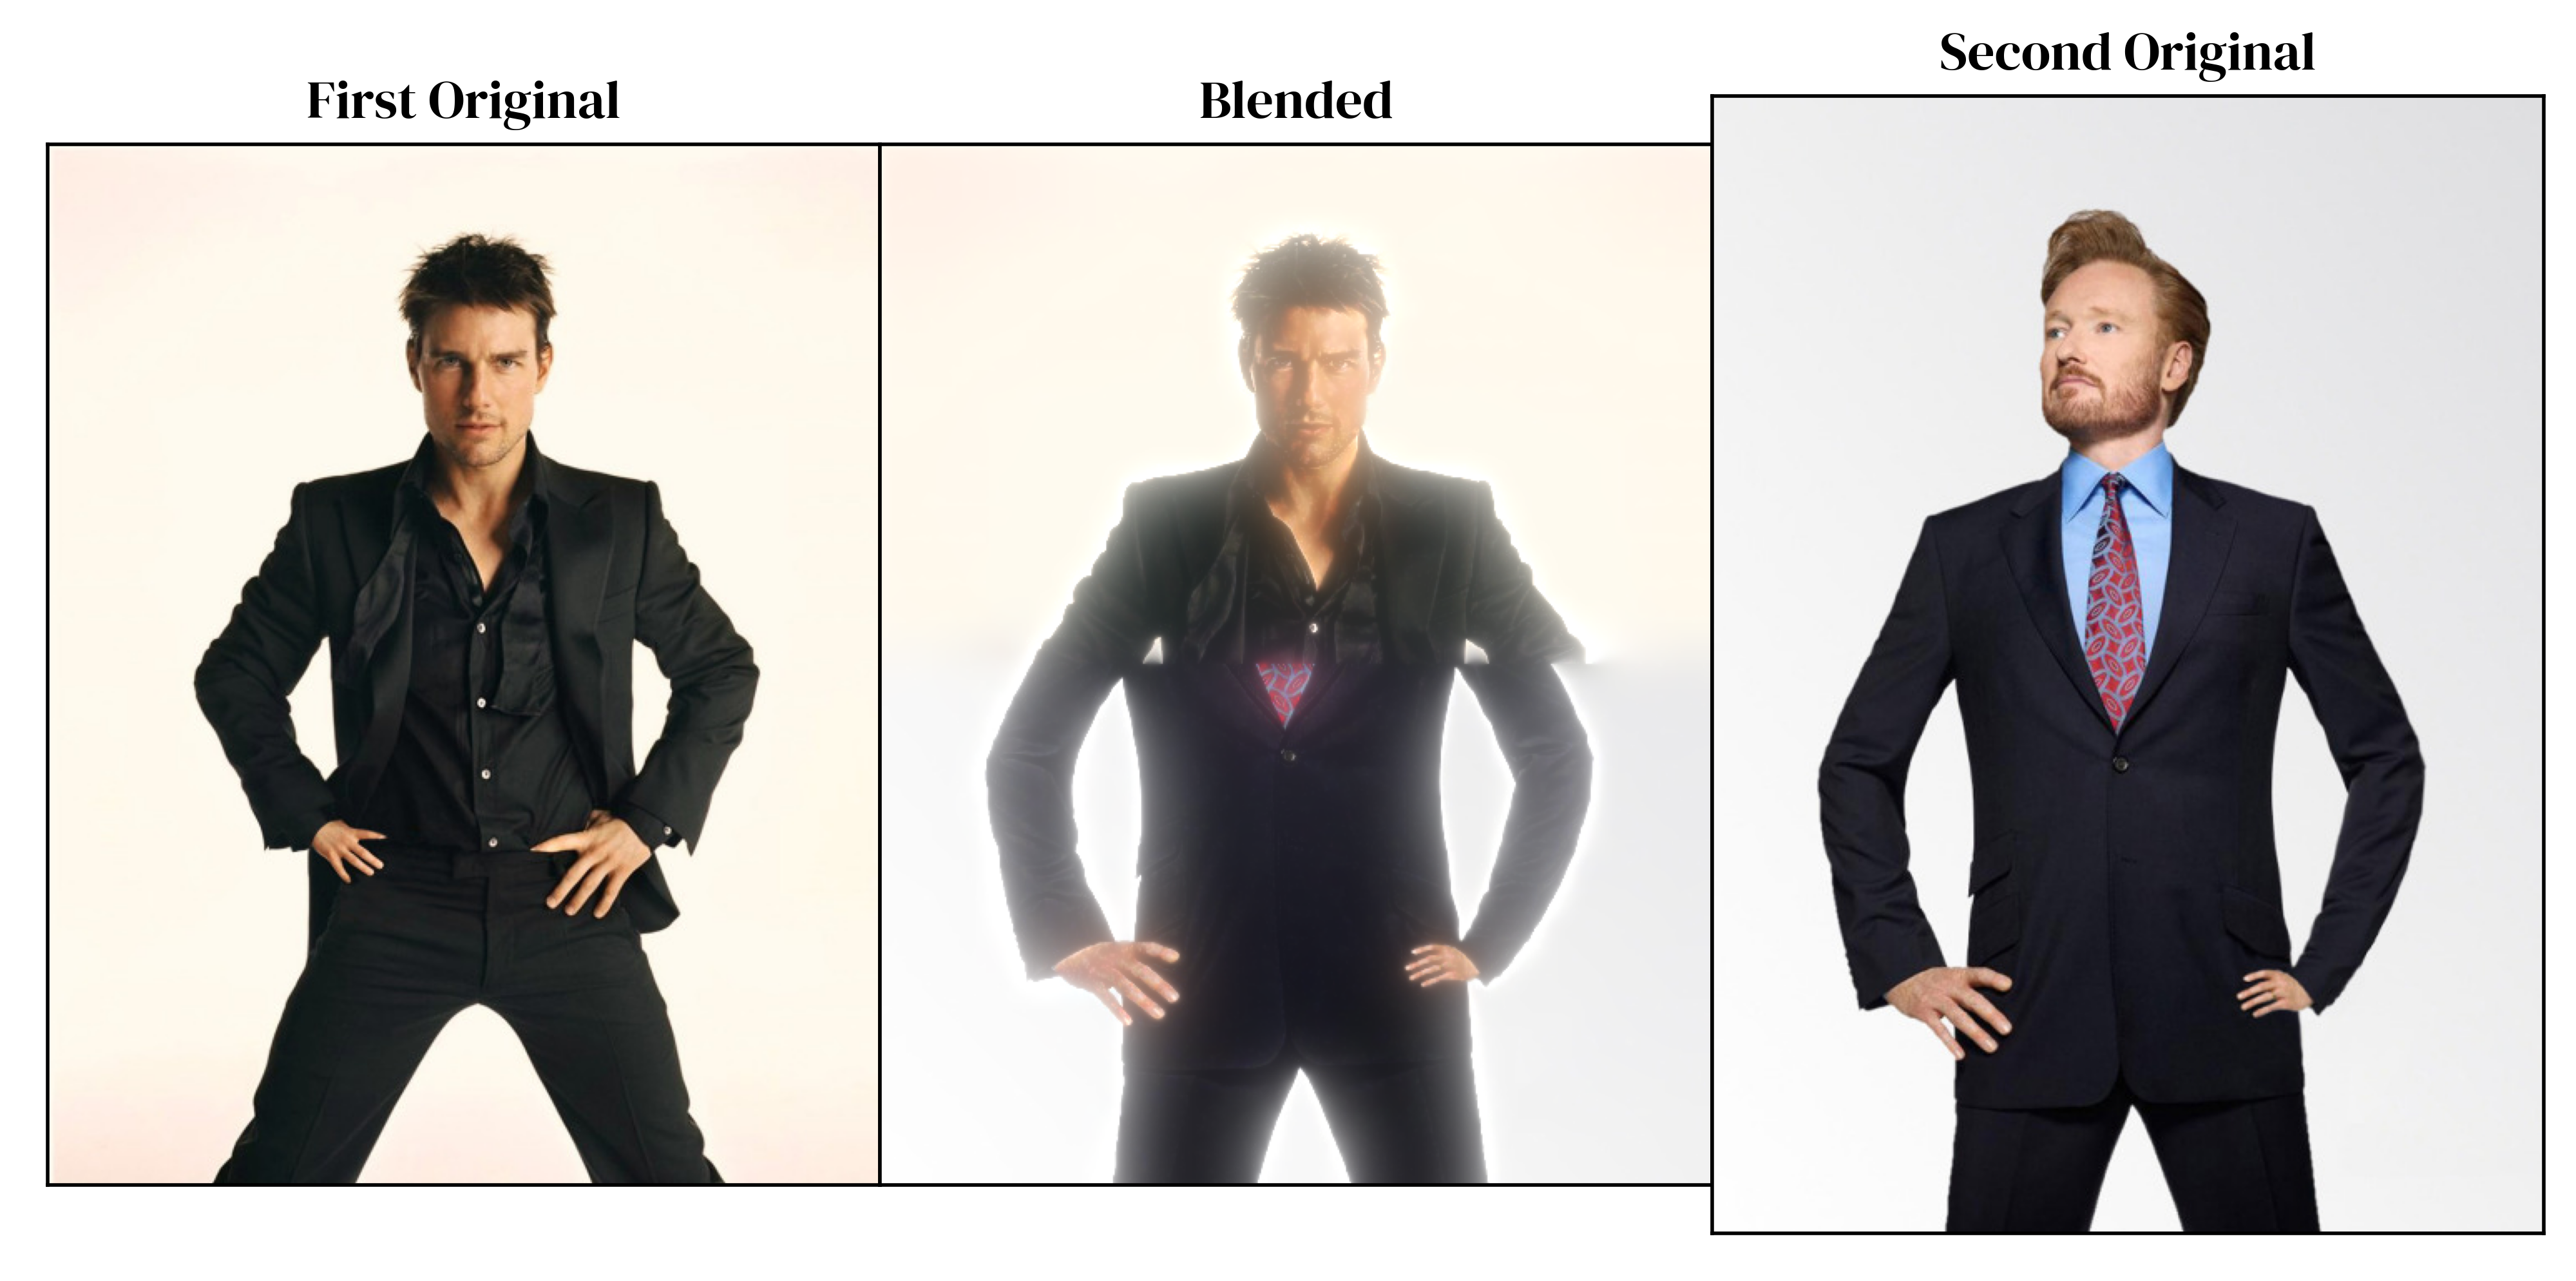

In [37]:
pic_1 = './data/original_pictures/tumblr_m0oycaP6Dl1rodz1bo1_500.jpg'
pic_2 = './data/original_pictures/tumblr_m18hpym2Mn1rodz1bo1_500.jpg'
show_blended_pic(pic_1, pic_2)

In [56]:
pic = cv2.imread(pic_1)

In [54]:
out = np.zeros(pic.size, type(pic))

In [69]:
arr = np.array([[1,0],[0,1]])

In [ ]:
arr[]

In [67]:
pic[0,:]

array([[239, 250, 254],
       [239, 250, 254],
       [239, 250, 254],
       ...,
       [239, 251, 253],
       [239, 251, 253],
       [239, 251, 253]], dtype=uint8)

In [55]:
pic(cv2.rectangle(0, 10, pic[,:], pic.rows - 10)).copyTo(out(cv2.rectangle(0, 0, pic.cols, pic.rows-10)))

AttributeError: 'numpy.ndarray' object has no attribute 'cols'

In [12]:
# def collection_to_df(self):
#         self.resize_collection()
#         cols_ls = []
#         for i in range(self.resized_collection[0].height):
#             for j in range(self.resized_collection[0].width):
#                 cols_ls.append(f"Pixel_{i}_{j}")
#         rows_of_df = [i.data.ravel() for i in self.resized_collection]
#         return PicCollectionDf(rows = rows_of_df, columns = cols_ls)

# class PicCollectionDf(pd.DataFrame):
    
#     def __init__(self, rows, columns):
#         super().__init__(data = rows, columns = columns)